In [7]:
from load_data import *

In [8]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/3Hz_trial2/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[6])
    print(f"Keys in {imus[6]}:", keys)

Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BFD802900B5: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


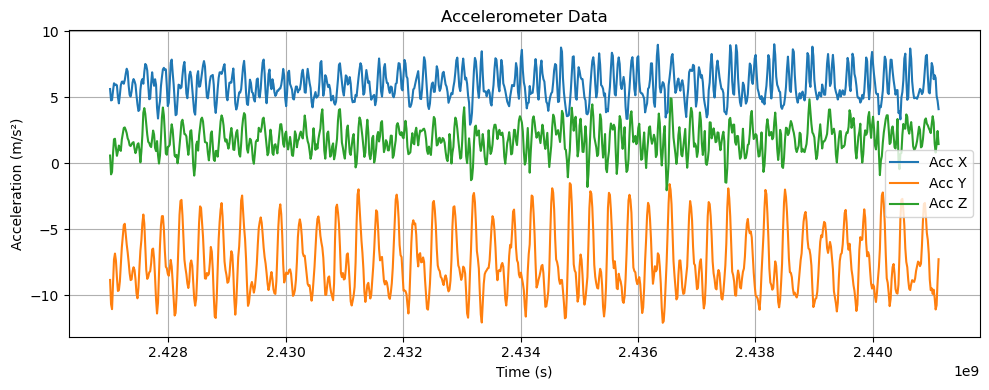

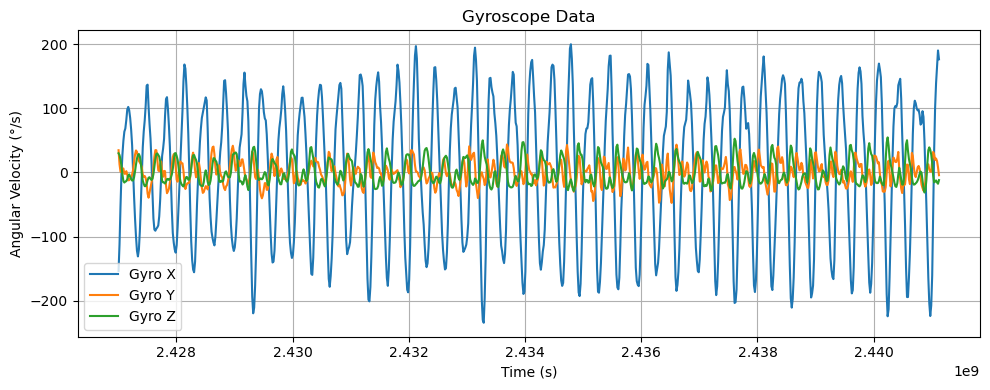

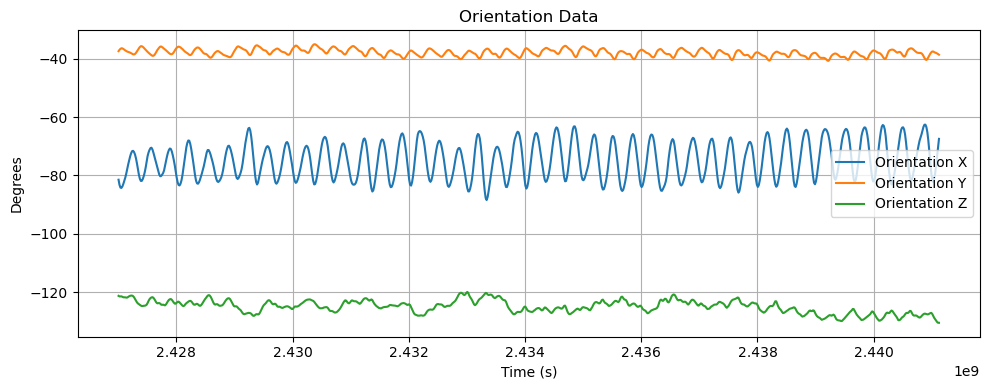

In [9]:
acc, gyro, orient, time = load_imu_data(path, imus[6])
plot_imu_data(acc, gyro, orient, time)

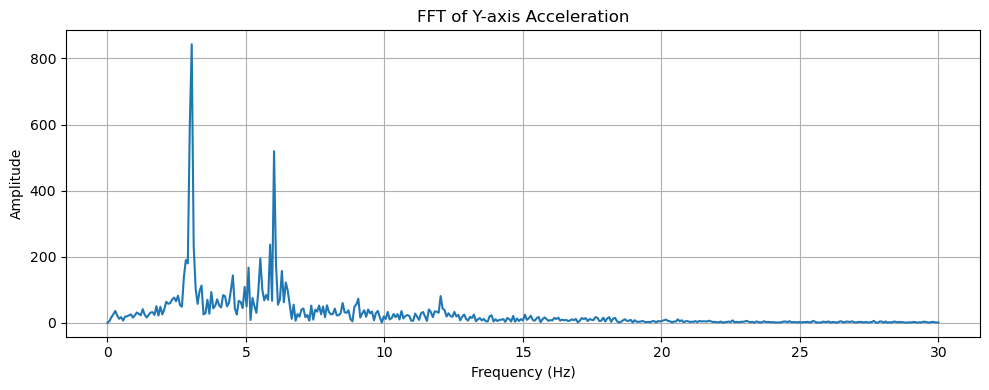

In [10]:
# Assume acc is your accelerometer array and fs = 60 Hz
y_axis_signal = acc[1]
signal_clean = preprocess_signal(y_axis_signal)
freqs, fft_vals = compute_fft(signal_clean, fs=60)
plot_fft(freqs, fft_vals, title="FFT of Y-axis Acceleration")

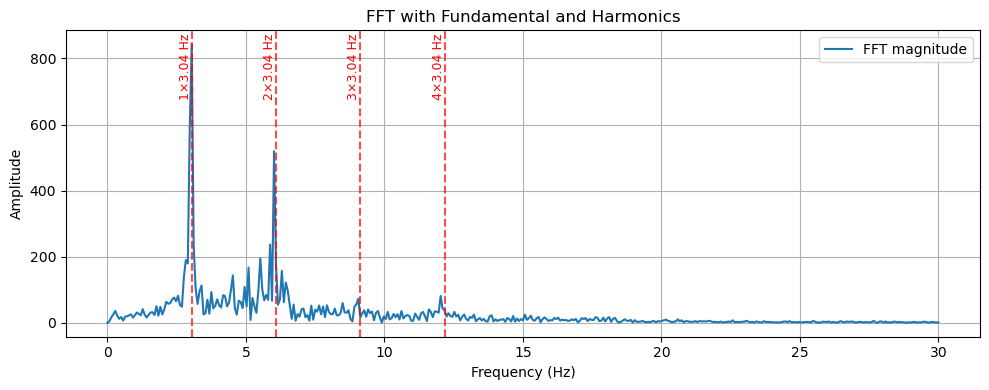

Fundamental frequency: 3.04 Hz


In [11]:
# Example using Y-axis accelerometer data
fund_freq = analyze_fft_with_harmonics(acc[1], fs=60, n_harmonics=4)
print(f"Fundamental frequency: {fund_freq:.2f} Hz")

In [12]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# Assume you already loaded these from your HDF5:
# acc: shape (3, N)
# orient: shape (3, N)

# Transpose to shape (N, 3)
acc = acc.T
orient = orient.T

# Compute rotation matrices from orientation (Euler angles in degrees)
rot = R.from_euler('xyz', orient, degrees=True)

# Rotate acceleration into world frame
acc_world = rot.apply(acc)

# Subtract gravity (assuming gravity vector is [0, 0, 9.81])
acc_world -= np.array([0, 0, 9.81])

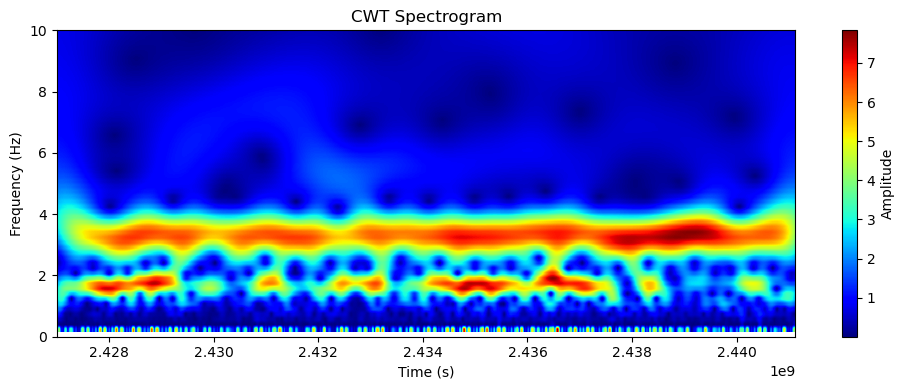

In [13]:
# Choose one axis (e.g., Y-axis of tremor_band or acc_world)
signal = acc_world[:, 1]  # Y-axis
signal = signal - np.mean(signal)  # Remove DC offset if needed

cwt_matrix, freqs = analyze_cwt_spectrogram(signal, time, fs=60, max_freq=10)

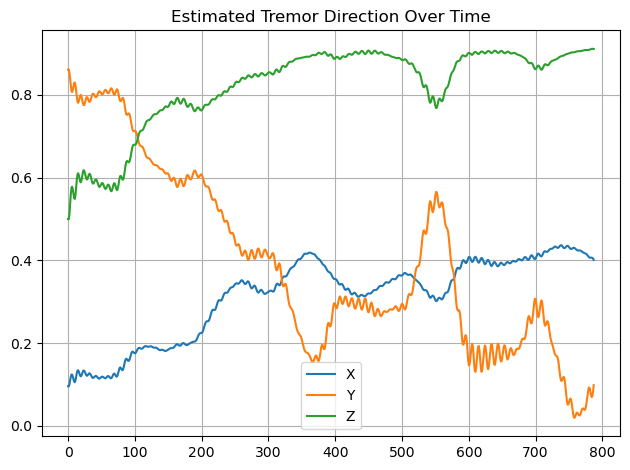

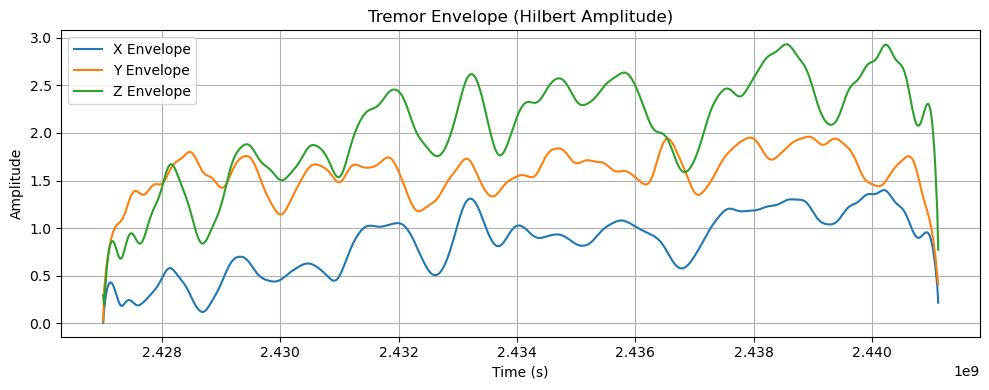

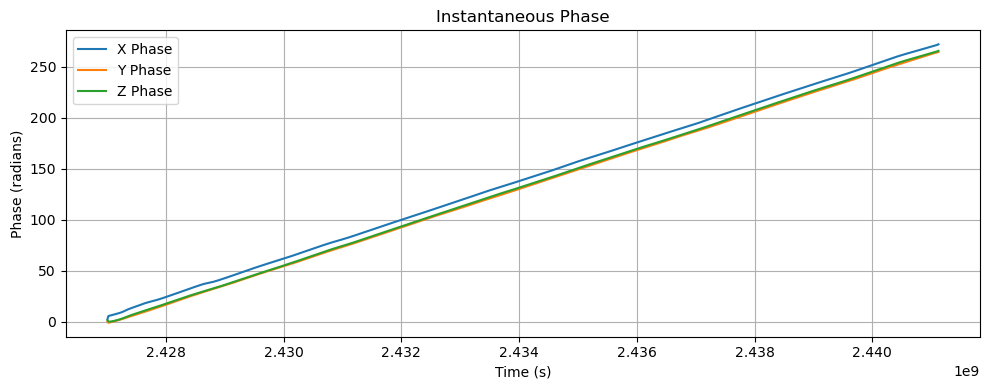

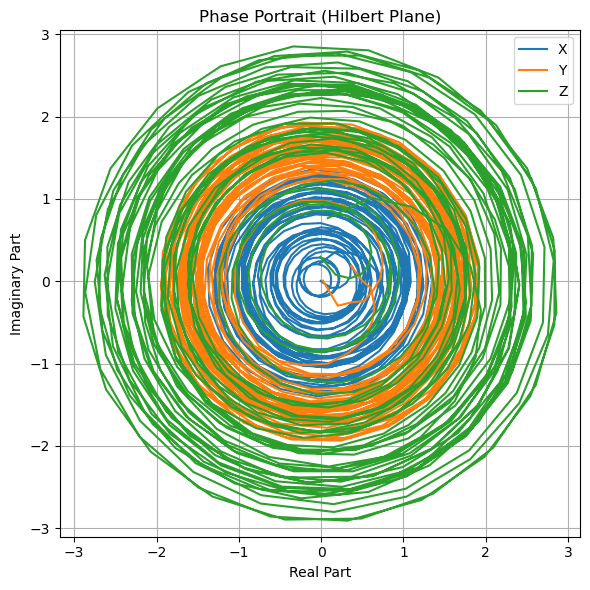

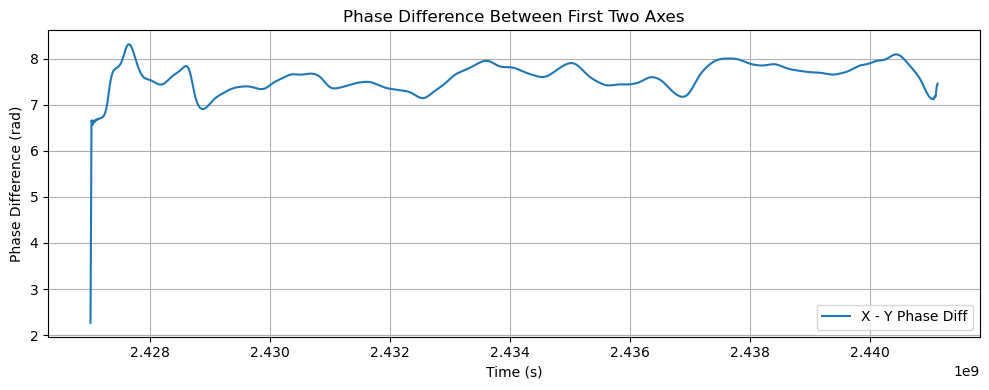

In [14]:
# Step 1: Filter the raw acceleration to get tremor band
tremor_band = bandpass_filter(acc_world, lowcut=2, highcut=4, fs=60)

# Step 2: Estimate tremor direction (dominant axis over time)
tremor_dir_vectors = estimate_tremor_direction_pca(tremor_band, fs=60)

# Step 3: Plot tremor direction over time
import matplotlib.pyplot as plt
plt.plot(tremor_dir_vectors[:, 0], label='X')
plt.plot(tremor_dir_vectors[:, 1], label='Y')
plt.plot(tremor_dir_vectors[:, 2], label='Z')
plt.title("Estimated Tremor Direction Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Apply Hilbert transform and analyze envelope & phase (on filtered tremor_band!)
envelope, phase, analytic_signal = analyze_tremor_hilbert(
    tremor_band,
    time[:tremor_band.shape[0]],  # time array must match length
    axis_labels=['X', 'Y', 'Z']
)

Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BFD802900B5: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


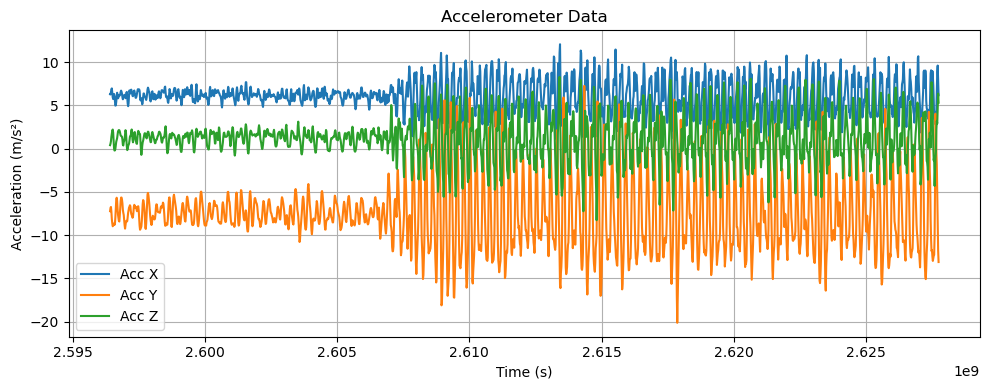

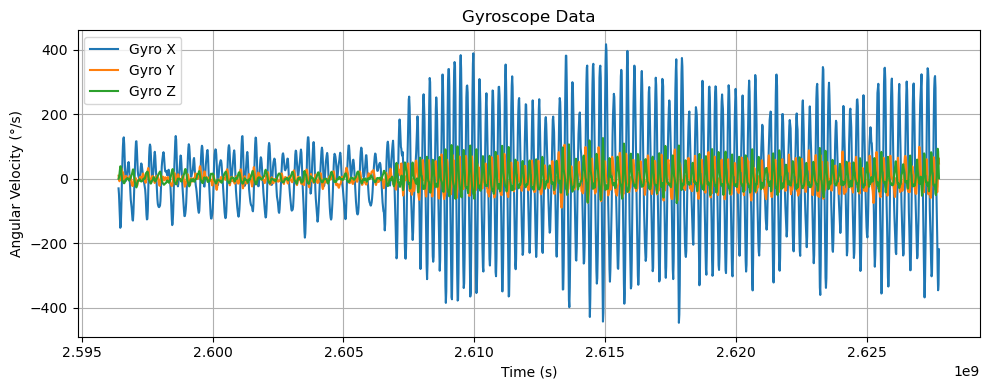

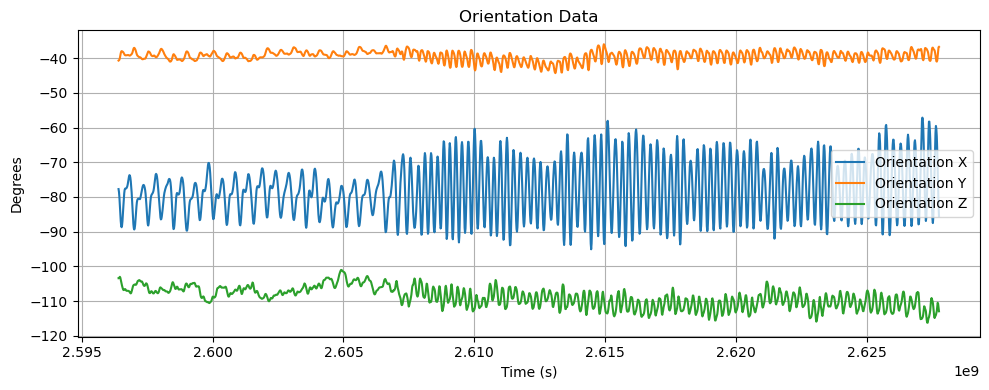

In [18]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/2Hz_4Hz_trial1/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[6])
    print(f"Keys in {imus[6]}:", keys)

acc, gyro, orient, time = load_imu_data(path, imus[6])
plot_imu_data(acc, gyro, orient, time)

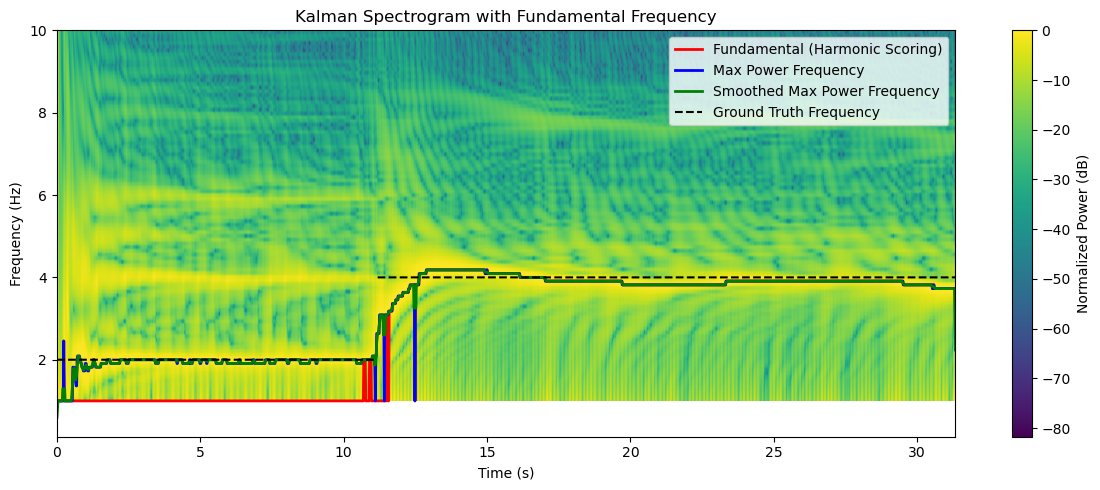

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# --- 1. Preprocessing function ---
def preprocess_signal(signal, fs, lowcut=1.0, highcut=10.0):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, [low, high], btype='band')
    return filtfilt(b, a, signal)

# --- 2. Updated Kalman filter bank ---
def kalman_filter_bank_spectrogram(signal, fs, freqs, q=1e-4, r=1e-1,
                                   power_bias=1.5, process_noise_bias=1.5):
    N = len(signal)
    dt = 1 / fs
    spec = np.zeros((len(freqs), N))
    uncertainty = np.zeros((len(freqs), N))

    for i, f in enumerate(freqs):
        omega = 2 * np.pi * f
        x = np.zeros(2)
        P = np.eye(2)
        Q = (q / (f**process_noise_bias)) * np.eye(2)
        R = r

        for k in range(N):
            H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
            y = signal[k]

            x_pred = x
            P_pred = P + Q

            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T / S
            x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
            P = (np.eye(2) - K @ H) @ P_pred

            power = np.sum(x ** 2) / (f**power_bias)
            spec[i, k] = power
            uncertainty[i, k] = np.trace(P)  # total state uncertainty

    return spec, uncertainty


# --- 3. Harmonic-based fundamental frequency detection ---
def harmonic_score_column(spec_col, freqs, max_harmonics=4, threshold=0.5):
    scores = []
    f_max = freqs[-1]

    for i, f in enumerate(freqs):
        harmonics = []
        for h in range(1, max_harmonics + 1):
            f_h = f * h
            if f_h > f_max:
                continue
            idx = np.argmin(np.abs(freqs - f_h))
            if idx < len(spec_col) and spec_col[idx] > threshold:
                harmonics.append(spec_col[idx] / h**2)
        scores.append(np.sum(harmonics) if harmonics else 0.0)

    return scores

def extract_fundamental_from_spec(spec, freqs, fs, max_harmonics=4, threshold=0.5):
    fundamental_freqs = []
    for k in range(spec.shape[1]):
        spec_col = spec[:, k]
        scores = harmonic_score_column(spec_col, freqs, max_harmonics=max_harmonics, threshold=threshold)
        best_idx = np.argmax(scores)
        fundamental_freqs.append(freqs[best_idx])
    return np.array(fundamental_freqs)

# --- 4. Plotting ---
def plot_kalman_spectrogram_with_fundamental(spec, freqs, fs, fundamental_freqs, title='Kalman Spectrogram with Fundamental'):
    t = np.arange(spec.shape[1]) / fs
    spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

    plt.figure(figsize=(12, 5))
    plt.imshow(spec_db, extent=[t[0], t[-1], freqs[0], freqs[-1]],
               aspect='auto', origin='lower', cmap='viridis')
    plt.plot(t, fundamental_freqs, color='red', linewidth=2, label='Fundamental (Harmonic Scoring)')
    #plot freq qith max power at that timepoint
    max_power_indices = np.argmax(spec, axis=0)
    max_power_freqs = freqs[max_power_indices]
    plt.plot(t, max_power_freqs, color='blue', linewidth=2, label='Max Power Frequency')
    #smoothed max power over time
    smoothed_max_power_freqs = np.convolve(max_power_freqs, np.ones(5)/5, mode='same')
    plt.plot(t, smoothed_max_power_freqs, color='green', linewidth=2, label='Smoothed Max Power Frequency')

    ground_truth_freqs = np.ones(len(t))*2  # Example ground truth frequencies
    ground_truth_freqs[670:] = ground_truth_freqs[670:]*2.0  # First 650 samples at 2 Hz
    ground_truth_freqs[670] = np.nan
    plt.plot(t, ground_truth_freqs, color='black', linestyle='--', label='Ground Truth Frequency')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.colorbar(label='Normalized Power (dB)')
    plt.legend()
    plt.tight_layout()
    plt.show()
fs = 60  # Sampling frequency
preprocessed = preprocess_signal(acc[1], fs)  # Preprocess Y-axis accelerometer data
freq_grid = np.linspace(1, 10, 100)  # 1–10 Hz, 100 bins
spec, uncertainty = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid, power_bias=1.5, process_noise_bias=1.5)

fundamental_freqs = extract_fundamental_from_spec(spec, freq_grid, fs, max_harmonics=4, threshold=0.5)
plot_kalman_spectrogram_with_fundamental(spec, freq_grid, fs, fundamental_freqs, title='Kalman Spectrogram with Fundamental Frequency')
#spec, uncertainty = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid)

# max_power_indices = np.argmax(spec, axis=0)
# uncertainty_trace = uncertainty[max_power_indices, np.arange(spec.shape[1])]
# t = np.arange(spec.shape[1]) / fs
# max_freqs = freq_grid[max_power_indices]



# plt.figure(figsize=(12, 4))
# plt.plot(t[10:], uncertainty_trace[10:], 'r-', label='Max Power Frequency')

# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.legend()
# plt.title('Frequency Estimate with Kalman Uncertainty')
# plt.tight_layout()
# plt.grid(True)
# plt.show()


# def compute_frequency_uncertainty(spec, freqs):
#     """
#     Compute frequency uncertainty as the power-weighted standard deviation
#     for each timepoint.
#     """
#     spec_sum = np.sum(spec, axis=0, keepdims=True) + 1e-10  # normalize to avoid divide-by-zero
#     weights = spec / spec_sum
#     mean_freqs = np.sum(weights * freqs[:, None], axis=0)
#     var_freqs = np.sum(weights * (freqs[:, None] - mean_freqs[None, :])**2, axis=0)
#     stddev_freqs = np.sqrt(var_freqs)
#     return mean_freqs, stddev_freqs

# def plot_with_uncertainty(t, fundamental_freqs, mean_freqs, stddev_freqs, ground_truth=None):
#     """
#     Plot estimated frequencies with uncertainty bands.
#     """
#     plt.figure(figsize=(12, 4))
#     plt.plot(t, fundamental_freqs, 'r-', label='Fundamental Estimate')
#     plt.plot(t, mean_freqs, 'b--', label='Power-Weighted Mean Frequency')
#     plt.fill_between(t, mean_freqs - stddev_freqs, mean_freqs + stddev_freqs,
#                      color='blue', alpha=0.3, label='Uncertainty (±1σ)')
#     if ground_truth is not None:
#         plt.plot(t, ground_truth, 'k-', linewidth=2, label='Ground Truth')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Frequency (Hz)')
#     plt.title('Fundamental Frequency with Uncertainty')
#     plt.legend()
#     plt.tight_layout()
#     plt.grid(True)
#     plt.show()


# t = np.arange(spec.shape[1]) / fs
# mean_freqs, stddev_freqs = compute_frequency_uncertainty(spec, freq_grid)

# # Optional: generate ground truth (e.g., 2 Hz for 0–10s, 4 Hz after)
# ground_truth = np.ones_like(t) * 2
# ground_truth[int(len(t)//2):] = 4

# plot_with_uncertainty(t, fundamental_freqs, mean_freqs, stddev_freqs, ground_truth)



In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


def preprocess_signal(signal, fs, lowcut=1.0, highcut=10.0):
    """Bandpass filter the input signal between lowcut and highcut Hz."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, [low, high], btype='band')
    return filtfilt(b, a, signal)


def kalman_filter_bank_spectrogram(signal, fs, freqs, q=1e-4, r=1e-1,
                                   power_bias=1.5, process_noise_bias=1.5):
    """Estimate time-frequency power via a Kalman filter bank."""
    N = len(signal)
    dt = 1 / fs
    spec = np.zeros((len(freqs), N))
    uncertainty = np.zeros((len(freqs), N))

    for i, f in enumerate(freqs):
        omega = 2 * np.pi * f
        x = np.zeros(2)
        P = np.eye(2)
        Q = (q / (f**process_noise_bias)) * np.eye(2)
        R = r

        for k in range(N):
            H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
            y = signal[k]

            x_pred = x
            P_pred = P + Q

            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T / S
            x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
            P = (np.eye(2) - K @ H) @ P_pred

            power = np.sum(x ** 2) / (f**power_bias)
            spec[i, k] = power
            uncertainty[i, k] = np.trace(P)

    return spec, uncertainty


def harmonic_score_column(spec_col, freqs, max_harmonics=4, threshold=0.5):
    scores = []
    f_max = freqs[-1]
    for i, f in enumerate(freqs):
        harmonics = []
        for h in range(1, max_harmonics + 1):
            f_h = f * h
            if f_h > f_max:
                continue
            idx = np.argmin(np.abs(freqs - f_h))
            if idx < len(spec_col) and spec_col[idx] > threshold:
                harmonics.append(spec_col[idx] / h**2)
        scores.append(np.sum(harmonics) if harmonics else 0.0)
    return scores


def extract_fundamental_from_spec(spec, freqs, fs, max_harmonics=4, threshold=0.5):
    fundamental_freqs = []
    all_scores = []
    for k in range(spec.shape[1]):
        spec_col = spec[:, k]
        scores = harmonic_score_column(spec_col, freqs, max_harmonics=max_harmonics, threshold=threshold)
        best_idx = np.argmax(scores)
        fundamental_freqs.append(freqs[best_idx])
        all_scores.append(scores)
    return np.array(fundamental_freqs), np.array(all_scores)


def compute_frequency_uncertainty(spec, freqs):
    """Compute power-weighted mean and std deviation of frequency."""
    spec_sum = np.sum(spec, axis=0, keepdims=True) + 1e-10
    weights = spec / spec_sum
    mean_freqs = np.sum(weights * freqs[:, None], axis=0)
    var_freqs = np.sum(weights * (freqs[:, None] - mean_freqs[None, :])**2, axis=0)
    stddev_freqs = np.sqrt(var_freqs)
    return mean_freqs, stddev_freqs


def plot_all_kalman_analysis(signal, fs, freqs, spec, fundamental_freqs, harmonic_scores, uncertainty):
    t = np.arange(len(signal)) / fs
    max_power_indices = np.argmax(spec, axis=0)
    max_power_freqs = freqs[max_power_indices]
    smoothed_max_freqs = np.convolve(max_power_freqs, np.ones(5)/5, mode='same')
    spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

    # 1. Spectrogram with overlays
    plt.figure(figsize=(12, 5))
    plt.imshow(spec_db, extent=[t[0], t[-1], freqs[0], freqs[-1]], aspect='auto', origin='lower', cmap='viridis')
    plt.plot(t, fundamental_freqs, 'r-', label='Fundamental (harmonic scoring)')
    plt.plot(t, max_power_freqs, 'b--', label='Max Power Frequency')
    plt.plot(t, smoothed_max_freqs, 'g-', label='Smoothed Max Frequency')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Kalman Spectrogram with Harmonic Scoring")
    plt.colorbar(label="Power (dB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Harmonic scores over time
    plt.figure(figsize=(12, 4))
    plt.plot(t, [np.max(score_row) for score_row in harmonic_scores], 'm-', label='Max Harmonic Score')
    plt.title("Harmonic Score Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Frequency estimate with uncertainty
    mean_freqs, stddev_freqs = compute_frequency_uncertainty(spec, freqs)
    plt.figure(figsize=(12, 4))
    plt.plot(t, fundamental_freqs, 'r-', label='Fundamental Estimate')
    plt.plot(t, mean_freqs, 'b--', label='Power-Weighted Mean Freq')
    plt.fill_between(t, mean_freqs - stddev_freqs, mean_freqs + stddev_freqs,
                     color='blue', alpha=0.3, label='Uncertainty (±1σ)')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Frequency Estimate with Uncertainty")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_kalman_tremor_analysis(signal, fs, freq_grid):
    signal_filt = preprocess_signal(signal, fs)
    spec, uncertainty = kalman_filter_bank_spectrogram(signal_filt, fs, freq_grid)
    fundamental_freqs, harmonic_scores = extract_fundamental_from_spec(spec, freq_grid, fs)
    plot_all_kalman_analysis(signal_filt, fs, freq_grid, spec, fundamental_freqs, harmonic_scores, uncertainty)
    return spec, fundamental_freqs, harmonic_scores, uncertainty

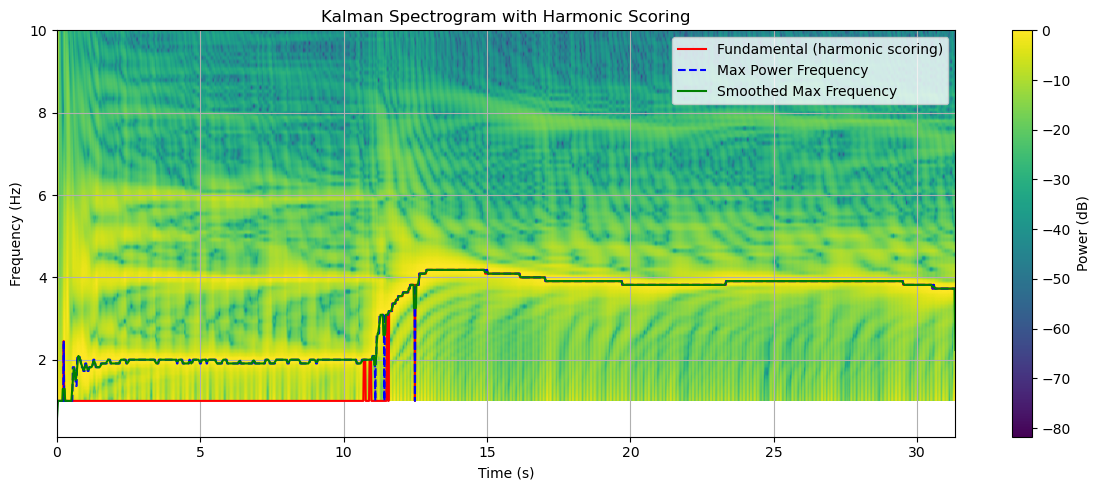

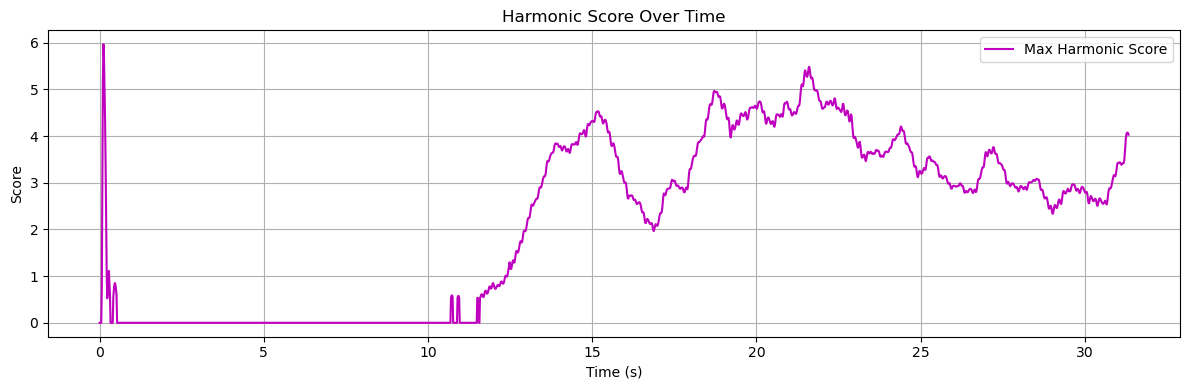

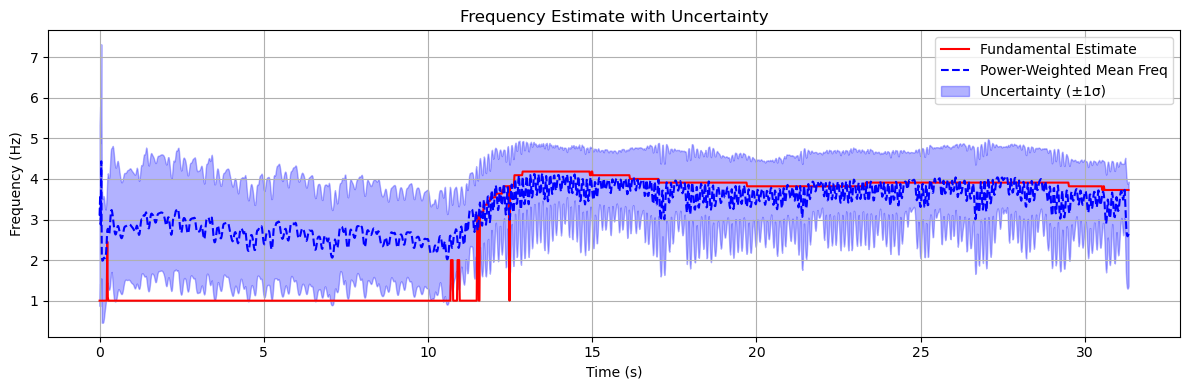

In [24]:
fs = 60
freq_grid = np.linspace(1, 10, 100)
signal = acc[1]  # e.g., Y-axis accelerometer

spec, fundamental_freqs, harmonic_scores, uncertainty = run_kalman_tremor_analysis(signal, fs, freq_grid)

In [26]:
def reconstruct_spectrogram_from_estimates(mean_freqs, freqs, sigma=0.1):
    """
    Reconstruct a simplified spectrogram using Gaussian blobs centered on smoothed frequencies.
    Each time point receives a Gaussian distribution centered at the estimated frequency.
    """
    T = len(mean_freqs)
    F = len(freqs)
    recon_spec = np.zeros((F, T))

    for k in range(T):
        gaussian = np.exp(-0.5 * ((freqs - mean_freqs[k]) / sigma)**2)
        gaussian /= gaussian.sum()
        recon_spec[:, k] = gaussian

    return recon_spec

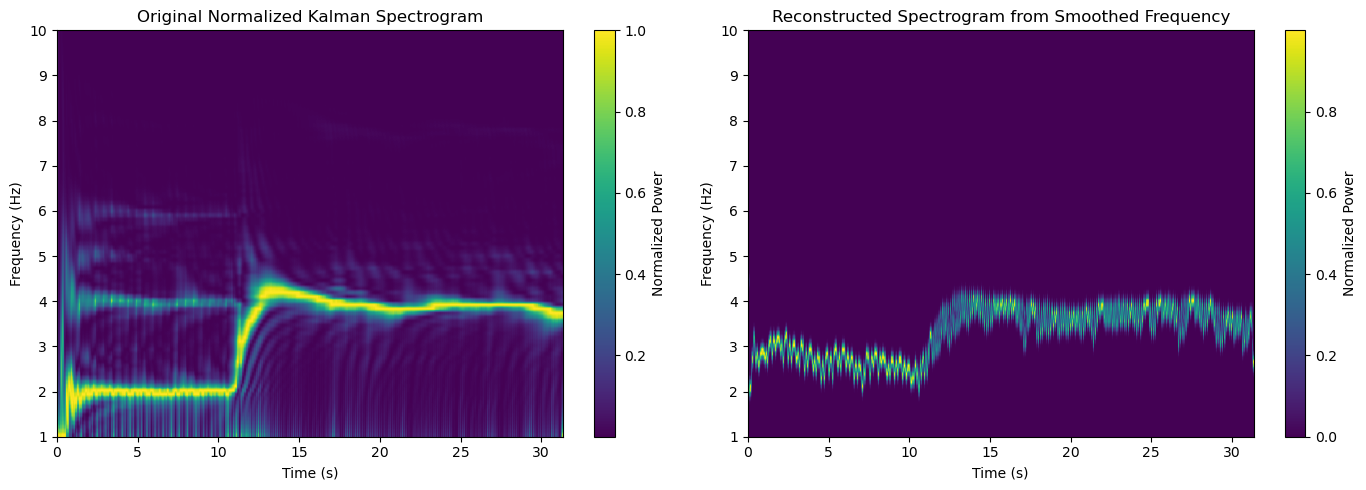

In [31]:
# Reconstruct and plot spectrogram from smoothed mean frequencies
mean_freqs, _ = compute_frequency_uncertainty(spec, freq_grid)
recon_spec = reconstruct_spectrogram_from_estimates(mean_freqs, freq_grid, sigma=0.1)

# Compute time axis and normalize both spectrograms
t = np.arange(spec.shape[1]) / fs
spec_norm = spec / (np.max(spec, axis=0, keepdims=True) + 1e-10)
recon_spec_norm = recon_spec / (np.max(recon_spec, axis=0, keepdims=True) + 1e-10)

# Create figure with two subplots
plt.figure(figsize=(14, 5))

# Subplot 1: Original normalized spectrogram
plt.subplot(1, 2, 1)
plt.imshow(spec_norm, extent=[t[0], t[-1], freq_grid[0], freq_grid[-1]],
           aspect='auto', origin='lower', cmap='viridis')
plt.title("Original Normalized Kalman Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Normalized Power")

# Subplot 2: Reconstructed normalized spectrogram
plt.subplot(1, 2, 2)
plt.imshow(recon_spec_norm, extent=[t[0], t[-1], freq_grid[0], freq_grid[-1]],
           aspect='auto', origin='lower', cmap='viridis')
plt.title("Reconstructed Spectrogram from Smoothed Frequency")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Normalized Power")

plt.tight_layout()
plt.show()

In [ ]:
# import matplotlib.animation as animation
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# def animate_kalman_spectrogram(spec, freqs, fs, interval=100, smooth_window=5):
#     t = np.arange(spec.shape[1]) / fs
#     spec_db_full = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))
#     spec_db = np.full_like(spec_db_full, np.nan)

#     true_freq = np.ones_like(t) * 2
#     true_freq[650:] = 4

#     max_power_indices = np.argmax(spec, axis=0)
#     max_power_freqs = freqs[max_power_indices]
#     smoothed_max_power = np.convolve(max_power_freqs, np.ones(smooth_window)/smooth_window, mode='same')

#     # Create masked array for proper display of NaNs
#     fig, ax = plt.subplots(figsize=(12, 5))
#     cmap = plt.get_cmap('viridis').copy()
#     cmap.set_bad(color='white')  # show NaNs as black
#     spec_masked = np.ma.masked_invalid(spec_db)
#     img = ax.imshow(spec_masked, extent=[t[0], t[-1], freqs[0], freqs[-1]],
#                     aspect='auto', origin='lower', cmap=cmap,
#                     vmin=np.nanmin(spec_db_full), vmax=np.nanmax(spec_db_full))

#     line_true, = ax.plot([], [], 'k-', linewidth=2, label='Ground Truth (2→4 Hz)')
#     line_max, = ax.plot([], [], 'r-', linewidth=1.5, label='Max Power Frequency')
#     line_smooth, = ax.plot([], [], 'b-', linewidth=1.5, label='Smoothed Max Power')

#     ax.set_xlim(t[0], t[-1])
#     ax.set_ylim(freqs[0], freqs[-1])
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('Frequency (Hz)')
#     ax.set_title('Kalman Spectrogram (Progressive Reveal)')
#     ax.legend()
#     fig.colorbar(img, ax=ax, label='Normalized Power (dB)')

#     def update(frame):
#         spec_db[:, frame] = spec_db_full[:, frame]  # reveal one column
#         img.set_data(np.ma.masked_invalid(spec_db))  # refresh masked data

#         line_true.set_data(t[:frame+1], true_freq[:frame+1])
#         line_max.set_data(t[:frame+1], max_power_freqs[:frame+1])
#         line_smooth.set_data(t[:frame+1], smoothed_max_power[:frame+1])

#         return img, line_true, line_max, line_smooth

#     ani = animation.FuncAnimation(fig, update, frames=range(1, spec.shape[1]), interval=interval, blit=True)
#     plt.close(fig)
#     return ani

# # --- Prepare signal ---
# preprocessed = preprocess_signal(acc[1], fs)
# freq_grid = np.linspace(1, 10, 100)

# # --- Kalman spectrogram and fundamental frequency ---
# spec = kalman_filter_bank_spectrogram(preprocessed, fs, freq_grid, power_bias=1.5, process_noise_bias=1.5)
# fundamental_freqs = extract_fundamental_from_spec(spec, freq_grid, fs, max_harmonics=4, threshold=0.5)

# # --- Animate ---
# ani = animate_kalman_spectrogram(spec, freq_grid, fs,)
# from IPython.display import HTML
# import matplotlib as mpl
# mpl.rcParams['animation.embed_limit'] = 500  # in MB
# from matplotlib.animation import PillowWriter

# ani.save("kalman_spectrogram.gif", writer=PillowWriter(fps=60))
# print("Saved to disk successfully.")

# #HTML(ani.to_jshtml())
